In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import timeit
import re
import json
import pickle
import fastparquet
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.iolib.summary2 as summary2

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Nano patents
1. Get all nanotech patents
2. Sample within main industry; indicate whether the *tp* or *op* is a software patent

Code mostly taken from https://sfengc7.stern.nyu.edu:8888/notebooks/patentdiffusion/Results/Regressions/1-NewSample.ipynb
and https://sfengc7.stern.nyu.edu:8888/notebooks/patentdiffusion/Results/ExogSpillovers/2a-UniversityPatents-v2.ipynb#2.-Bayh-Dole-Sample

In [2]:
# 1. Software in abstract
pabs = fastparquet.ParquetFile("RawData/Cleaned/patabs7615_us_no_dup.parq").to_pandas()
print(len(pabs))
pabs = pabs.loc[pabs["abs_stemmed"].str.contains('nano', regex=True)]
print(len(pabs))
sw_pats = pabs["patent"]
print(len(sw_pats))
sw_pats.to_pickle("DataStore/2018-07-P2/Nano/nano_pats.pkl")
# del(pabs)

2575725
14096
14096


In [3]:
# Load data
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq").to_pandas()
print(len(pdf))
pdf = pdf.drop_duplicates("patent")
# Remove actual duplicates
dup_pats = pd.read_pickle("RawData/Cleaned/duplicate_pattext_0712.pkl")
pdf = pdf.loc[~(pdf["patent"].isin(dup_pats))]
print(len(pdf))
# Check that I have vector data for them
pabs = fastparquet.ParquetFile("RawData/Cleaned/patabs7615_us_no_dup.parq").to_pandas(["patent"])["patent"].tolist()
pdf = pdf.loc[pdf["patent"].isin(pabs)]
print(len(pdf))
del(dup_pats, pabs)

2523739
2220706
2002788


In [4]:
def get_year_group(x):
    if x in range(1975,1980):
        yg = "1975-80"
    elif x in range(1980,1985):
        yg = "1980-85"
    elif x in range(1985, 1990):
        yg = "1985-90"
    elif x in range(1990,1995):
        yg = "1990-95"
    elif x in range(1995,2000):
        yg = "1995-00"
    elif x in range(2000,2005):
        yg = "2000-05"
    elif x in range(2005,2010):
        yg = "2005-10"
    elif x in range(2010, 2015):
        yg = "2010-15"
    else:
        yg = np.nan
    return yg

pdf["year_group"] = pdf["appyear"].apply(get_year_group)
# Drop missing columns
pdf = pdf.dropna(how="any",subset=["appyear", "naics_name", "primclass", "year_group"])
print(len(pdf))

1521233


In [5]:
pdf.loc[pdf["patent"].isin(sw_pats), "naics_name"].value_counts()[:6]

Semiconductors and Other Electronic Components                      1505
Basic Chemicals                                                      707
Machinery                                                            685
Other Miscellaneous                                                  572
Other Chemical Product and Preparation                               568
Navigational, Measuring, Electromedical, and Control Instruments     548
Name: naics_name, dtype: int64

In [8]:
pdf.loc[pdf["patent"].isin(sw_pats), "appyear"].value_counts()

2003.0    730
2004.0    685
2005.0    671
2002.0    578
2006.0    533
2001.0    396
2007.0    314
2000.0    295
1999.0    259
1998.0    208
1997.0    172
1996.0    160
1995.0    150
2008.0    132
1994.0    111
1993.0     80
1992.0     68
1991.0     68
1989.0     44
1990.0     44
1987.0     39
1986.0     35
1988.0     29
1983.0     26
1976.0     26
1984.0     26
1980.0     25
2009.0     25
1981.0     24
1985.0     23
1977.0     22
1982.0     21
1975.0     19
1979.0     18
1978.0     17
Name: appyear, dtype: int64

In [8]:
c = "naics_name"
k = "year_group"
m = "inv_msa"
yr_min = 1990
yr_max = 2006
sw_pats = pd.read_pickle("DataStore/2018-07-P2/Nano/nano_pats.pkl")
ind = ["Semiconductors and Other Electronic Components"]

uni2 = pdf.loc[pdf[c].isin(ind) & pdf["patent"].isin(sw_pats) \
               & (pdf["appyear"].isin(range(yr_min, yr_max))),
              ["patent", "inv_msa", "appyear", "year_group", "naics_name", "primclass"]].copy().reset_index(drop=True)
uni2["tp_is_nano"] = True
p_rel = pdf.loc[pdf[c].isin(ind) & (pdf["appyear"].isin(range(yr_min, yr_max))), uni2.columns]
p2 = p_rel.sample(frac=0.6).reset_index(drop=True)
p2["tp_is_nano"] = False
targ = uni2.append(p2, ignore_index=True).reset_index(drop=True)
del(p2, uni2)

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if sys.path[0] == '':
/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [9]:
targ_g = targ.groupby([c,k,m]) # Each group is from same field, MSA, year group
p_c_m = p_rel.groupby([c,k,m]) # Each group is from same field, MSA, year group
p_c = p_rel.groupby([c,k]) # Each group from the same field, year group
ts = pd.DataFrame()
for n,g in targ_g:
    # Propagate the target patents
    # Get num x existing patent lists and randomize them
    num = 20
    p_all = []
    for i in range(num):
        p_all.extend(g["patent"].tolist())
    tp_in_msa = p_all
    if n in p_c_m.groups.keys():
        op_in_msa = p_c_m.get_group(n)["patent"].sample(n=len(tp_in_msa), replace=True).tolist()
        in_msa = pd.DataFrame({"tp": tp_in_msa, "op": op_in_msa})
        in_msa["samp"] = "In MSA"
    else:
        in_msa = pd.DataFrame()
    if (n[0], n[1]) in p_c.groups.keys():
        op_in_field = p_c.get_group((n[0], n[1]))["patent"].sample(n=len(tp_in_msa), replace=True).tolist()
        in_field = pd.DataFrame({"tp": tp_in_msa, "op": op_in_field})
        in_field["samp"] = "In Field"
    else:
        in_field = pd.DataFrame()   
    
    # Merge
    samp = pd.concat([in_msa, in_field], axis=0)
    if len(samp) > 0:
        # Remove where other is less than target
        samp = samp.loc[(samp["tp"] < samp["op"])]
        ts = ts.append(samp, ignore_index = True)

print(len(ts))

1142963


In [14]:
asgs = pickle.load(open("RawData/Cleaned/patent_assignee_dict_0628.pkl", "rb"))
# Check that target and other do not have same assignee
%time asg_match = (set(asgs.get(tp, [])).intersection(asgs.get(op, [])) for tp, op in zip(ts["tp"], ts["op"]))
%time asg_match = [len(i) for i in asg_match]

ts["asg_match"] = asg_match
ts = ts.loc[ts["asg_match"] == 0]
ts = ts.drop("asg_match",1)
print(len(ts))
del(asgs)

CPU times: user 59.3 ms, sys: 21.8 ms, total: 81.1 ms
Wall time: 80.6 ms
CPU times: user 2.42 s, sys: 8.72 ms, total: 2.43 s
Wall time: 2.42 s
1231274


In [10]:
ts.to_pickle("DataStore/2018-07-P2/Nano/nano_samp_0723.pkl")

## 2. Location measures
### 2.1. Location distributions of new patents at each year

In [2]:
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq").to_pandas(\
                                    ["patent", "appyear", "gyear", "naics_name", "primclass", "inv_msa"]).drop_duplicates("patent")
sw_pats = pd.read_pickle("DataStore/2018-07-P2/Nano/nano_pats.pkl")
sw_pats = pdf.loc[pdf["patent"].isin(sw_pats) & (pdf["appyear"] >=1980)]
del(pdf)

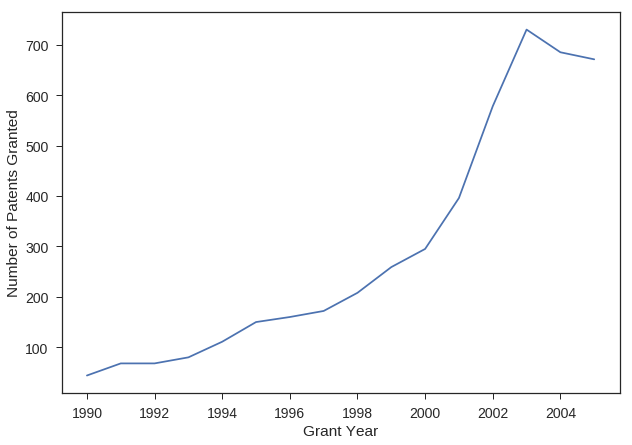

In [3]:
%matplotlib inline
sns.set(font_scale=1.4)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams.update({'font.size': 20})
savepath = "DataStore/2018-07-P3/ResultsGraphs/"

yr_min = 1990
yr_max = 2005

num_u = sw_pats.loc[sw_pats["appyear"].isin(range(yr_min, yr_max+1)), "appyear"].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(10,7))
num_u.plot.line(ax = ax)
ax.set_xlabel("Grant Year")
ax.set_ylabel("Number of Patents Granted")

# plt.savefig(savepath+"4a-NanoPatSize.png")
plt.show()

In [4]:
yr_min = 1990
yr_max = 2005
p3 = sw_pats.loc[(sw_pats["appyear"] >= yr_min) & (sw_pats["appyear"] <= yr_max)]
ploc = p3[["inv_msa", "appyear", "patent"]].groupby(["inv_msa", "appyear"]).count().reset_index()
# Only use those places with greater than 5 patents
ploc = ploc.loc[ploc["patent"] >= 5]
ploc = ploc.pivot(index="appyear", columns="inv_msa", values="patent").fillna(0)

# Get proportions
ploc = ploc.apply(lambda x: x/x.sum(), axis=1)

# Get number of cities
print(len(ploc.columns))

56


In [32]:
ploc

inv_msa,"Akron, OH","Albany-Schenectady-Troy, NY","Albuquerque, NM","Ann Arbor, MI","Atlanta-Sandy Springs-Marietta, GA","Austin-Round Rock-San Marcos, TX","Baltimore-Towson, MD","Binghamton, NY","Boise City-Nampa, ID","Boston-Cambridge-Quincy, MA-NH",...,"San Francisco-Oakland-Fremont, CA","San Jose-Sunnyvale-Santa Clara, CA","Santa Barbara-Santa Maria-Goleta, CA","Santa Fe, NM","Seattle-Tacoma-Bellevue, WA","State College, PA","Tampa-St. Petersburg-Clearwater, FL","Trenton-Ewing, NJ","Tucson, AZ","Washington-Arlington-Alexandria, DC-VA-MD-WV"
appyear,,,,,,,,,,,,,,,,,,,,,
1990.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1991.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.352941,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.294118
1992.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1993.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.241379,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1994.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.112903,...,0.096774,0.080645,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.129032
1995.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.135135,...,0.067568,0.067568,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067568
1996.0,0.000000,0.000000,0.086957,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.130435,...,0.076087,0.065217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076087
1997.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.223404,...,0.212766,0.053191,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.117021
1998.0,0.000000,0.000000,0.046296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,...,0.148148,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [5]:
sim = 1-sp.spatial.distance.cdist(ploc.values,ploc.values,metric="cosine")
# Make dataframe
sim = pd.DataFrame(sim, columns=list(range(yr_min,yr_max+1)), index=list(range(yr_min,yr_max+1))).unstack().reset_index()
sim.columns=["appyear1", "appyear2", "sim_location"]
sim["lag"] = sim["appyear2"]-sim["appyear1"]

In [6]:
# Timeline of lag1
sim1 = sim.loc[sim["lag"] == 1, ["appyear1", "sim_location"]].set_index("appyear1")

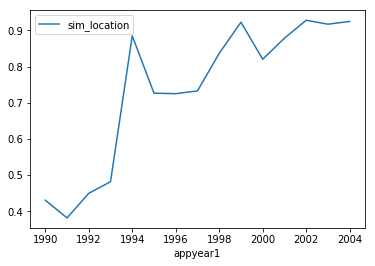

In [35]:
%matplotlib inline
# Plot
sim1.plot.line()

### 2.2 HHI

In [7]:
hhi = pd.Series(np.sum(ploc.values**2,axis=1), index = list(range(yr_min,yr_max+1)))

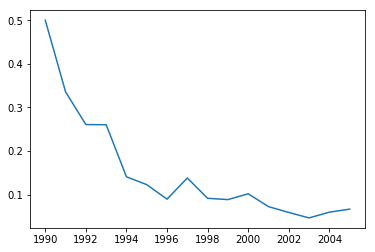

In [37]:
%matplotlib inline
# Plot
hhi.plot.line()

In [8]:
hhi

1990    0.500000
1991    0.335640
1992    0.260800
1993    0.260404
1994    0.140999
1995    0.123083
1996    0.089792
1997    0.138298
1998    0.091735
1999    0.088770
2000    0.102042
2001    0.072642
2002    0.059248
2003    0.046760
2004    0.059960
2005    0.066880
dtype: float64